# Subsampling LoFTR Matches

In [87]:
import os
import kornia as K
import numpy as np
import torch
import matplotlib.pyplot as plt
import math 
import skimage as ski

from utils import convert_image_to_tensor, match_sizes_resize
from DatasetTools.LeafImageSeries import LeafDataset
from masking import fetch_image_mask_pair
from loftr import loftr_match, warp_tps, tps_skimage
from registration import fetch_registered_image_mask_seq
from plotting import plot_image_series, plot_image_pair, plot_overlay, plot_match_coverage


In [2]:
leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070020_1",
    # leaf_uid="ESWW0070023_6", # has much missing data 
    load=('roi_leaf_masks'),
    # load=('target_images', 'target_masks', 'leaf_masks', 'seg_masks', 'det_masks', 'cropped_images', 'rois', 'images', 'keypoints', 'roi_leaf_masks'),
    verbose=False
)

Initializing dataset...
Getting Series...
Getting paths...
Extracting IDs...
Removing duplicate IDs...
Filtering by leaf_uid...
Compiling list...
Loading requested values...
Loading images...
Loading ROIs...
Loading Detection Masks...
Loading Segmentation Masks...
Generating Symptom Masks...


Processing series: 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]


Generating ROI Leaf Masks...


Processing series: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


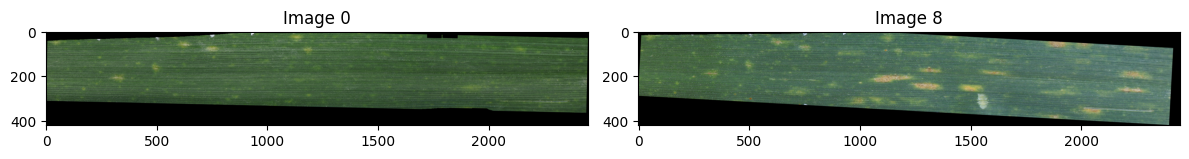

In [8]:
ind = 8
img_fixed, mask_fixed = fetch_image_mask_pair(leaf, 0, img_scale="roi")
img_moving, mask_moving = fetch_image_mask_pair(leaf, ind, img_scale="roi")
img_fixed, img_moving, mask_fixed, mask_moving = match_sizes_resize(img_fixed, img_moving, mask_fixed, mask_moving)
_ = plot_image_pair(img_fixed, img_moving, 0, ind)

Total matches: 4984
Matches with Confidence > 0.5: 3009
Inliers: 1141 (22.89%)


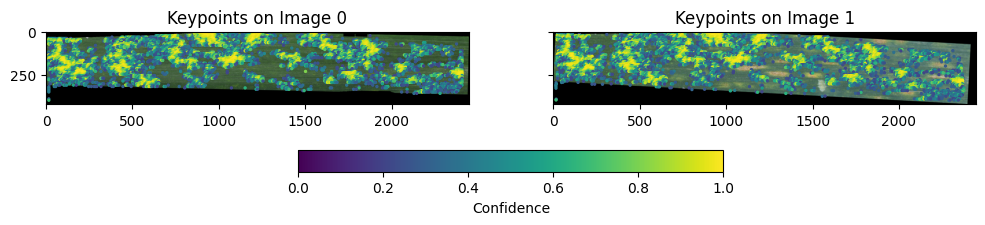

In [ ]:

mkpts0, mkpts1, confidence, inliers, n_matches = loftr_match(img_fixed, img_moving, verbose=True, return_n_matches=True)
_ = plot_match_coverage(img_fixed, mkpts0, img_moving, mkpts1, confidence)

## Grid

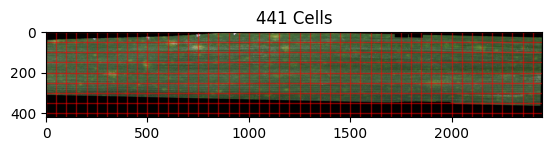

In [74]:
def plot_grid(img, cell_size=40):
    if type(img) == torch.Tensor:
        img = K.tensor_to_image(img)


    height, width = img.shape[:2]

    n_cols = math.ceil(width / cell_size)
    n_rows = math.ceil(height / cell_size)
    total_cells = n_rows * n_cols

    fig, ax = plt.subplots()
    ax.imshow(img)

    # Vertical lines
    for x in range(0, width, cell_size):
        ax.axvline(x=x, color='red', alpha=0.5, linewidth=1)

    # Horizontal lines
    for y in range(0, height, cell_size):
        ax.axhline(y=y, color='red', alpha=0.5, linewidth=1)
    
    ax.set_title(f"{total_cells} Cells")

    # plt.show()
    return fig, ax

fig, ax = plot_grid(img_fixed, 50)
fig.show()

## Spatial Binning based on Grid Cells

In [ ]:
# mkpts0[:,0] # x/width
cell_size = 50
W = img_fixed.shape[3]
num_cell_per_row =  math.ceil(W / cell_size)
cell_x = mkpts0[:,0] // cell_size
cell_y = mkpts0[:,1] // cell_size
cell_id = cell_y * num_cell_per_row + cell_x
num_ids = len(cell_id.unique())
cell_id

tensor([ 17.,  17.,  17.,  ..., 388., 343., 343.])

In [71]:
def group_by_argmax(values: torch.Tensor, groups: torch.Tensor):
    """
    Groups the values by group, determines the max for each group and returns the index of those values.

    Args:
        values: Values of which we want to find the max-per-group
        group: Tensor indicating which value belongs to which group

    Returns:
        list of indices of the max value for each group
    """
    # map group ids to consecutive values  0..num_unique-1
    unique_groups, inverse = torch.unique(groups, return_inverse=True)
    num_ids = len(unique_groups)

    # compute max value per group
    max_vals = torch.full((num_ids,), float('-inf'), device=values.device)
    max_vals = max_vals.scatter_reduce(
        0,
        inverse,
        values,
        reduce="amax",
        include_self=True
    )

    # find indices where value is the max
    is_max_mask = (values == max_vals[inverse])

    idx = torch.arange(len(values), device=values.device) # full list of indices
    idx_masked = torch.where(is_max_mask, idx, torch.full_like(idx, -1)) # non-max indices are set to -1

    # filter out indices of max per group
    argmax_idx = torch.full((num_ids,), -1, dtype=torch.long, device=values.device)
    argmax_idx = argmax_idx.scatter_reduce(
        0,
        inverse,
        idx_masked,
        reduce="amax",
        include_self=True
    )
    
    return argmax_idx

In [80]:
points = mkpts0[:20]
values = confidence[:20]
groups = cell_id[:20].long()

print(values)
print(groups)
group_by_argmax(values, groups)

tensor([0.8974, 0.8807, 0.8059, 0.8220, 0.9340, 0.9580, 0.9821, 0.9934, 0.9956,
        0.9987, 0.9995, 0.9845, 0.9938, 0.9962, 0.9951, 0.9721, 0.9580, 0.5092,
        0.3178, 0.5015])
tensor([17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19,
        20, 20])


tensor([ 5, 10, 13, 19])

In [75]:
cell_max_indices = group_by_argmax(confidence, cell_id.long())

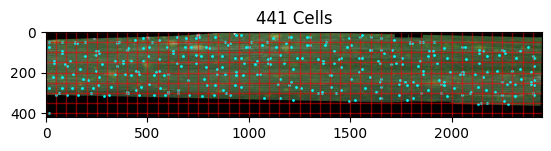

In [79]:
cell_max_coord = mkpts0[cell_max_indices, :]
fig, ax = plot_grid(img_fixed, 50)
ax.scatter(cell_max_coord[:, 0], cell_max_coord[:, 1], color='cyan', s=1)
fig.show()

In [97]:
def filter_matches_by_grid(mkpts0, mkpts1, confidence, img_width, threshold: float=0.5, cell_size: int=50):
    num_cell_per_row =  math.ceil(img_width / cell_size)

    cell_x = mkpts0[:,0] // cell_size
    cell_y = mkpts0[:,1] // cell_size
    cell_id = cell_y * num_cell_per_row + cell_x

    # get indices of max per cell
    cell_max_indices = group_by_argmax(confidence, cell_id.long())

    cell_max_coord0 = mkpts0[cell_max_indices, :]
    cell_max_coord1 = mkpts1[cell_max_indices, :]

    if threshold is not None:
        cell_max_coord0 = cell_max_coord0[confidence[cell_max_indices] > threshold]
        cell_max_coord1 = cell_max_coord1[confidence[cell_max_indices] > threshold]
    return cell_max_coord0, cell_max_coord1

Number of Matches: 431


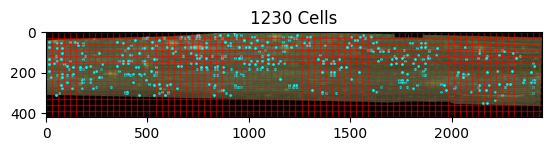

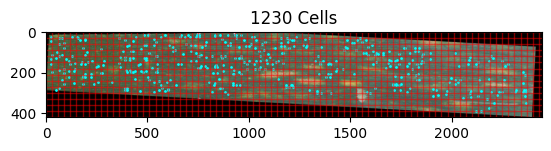

In [108]:
cell_size=30
threshold=0.7
cell_matches_fix, cell_matches_mov = filter_matches_by_grid(mkpts0, mkpts1, confidence, img_width=img_fixed.shape[3], cell_size=cell_size, threshold=threshold)
print(f"Number of Matches: {cell_matches_fix.shape[0]}")
fig, ax = plot_grid(img_fixed, cell_size)
ax.scatter(cell_matches_fix[:, 0], cell_matches_fix[:, 1], color='cyan', s=1)
fig.show()
fig, ax = plot_grid(img_moving, cell_size)
ax.scatter(cell_matches_mov[:, 0], cell_matches_mov[:, 1], color='cyan', s=1) # matches won't be neatly subdivided by cell in moving image anymore, since leaf changes
fig.show()

### TPS Test

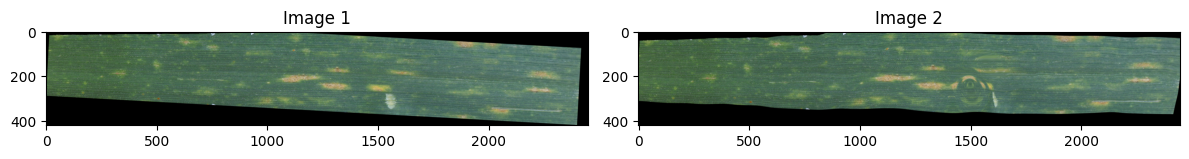

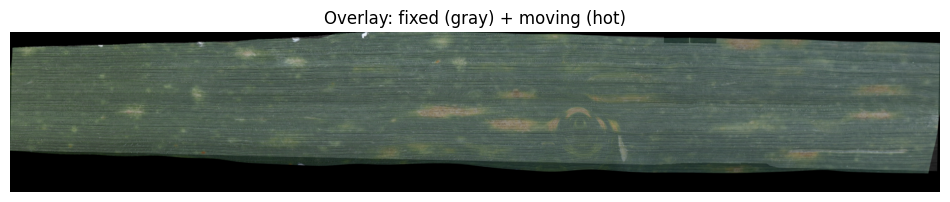

In [109]:
tps = ski.transform.ThinPlateSplineTransform.from_estimate(cell_matches_fix, cell_matches_mov)
out = warp_tps(img_moving, tps)
_=plot_image_pair(img_moving, out)
_=plot_overlay(img_fixed, out)

Setting threshold..
Threshold set to 0.9463129088000001
Estimating TPS transform...
Transforming moving image...


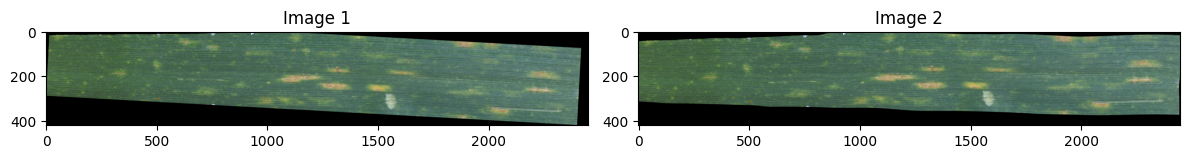

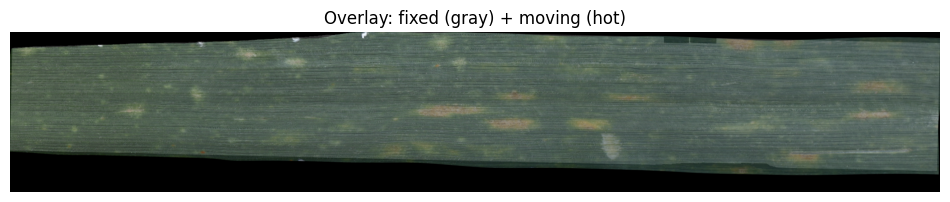

In [90]:
out_og, _ = tps_skimage(mkpts0, mkpts1, confidence, 0.5, img_moving, verbose=True)
_=plot_image_pair(img_moving, out_og)
_=plot_overlay(img_fixed, out_og)

## K-Means Clustering

In [133]:
threshold = 0.5
mkpts0_th = mkpts0[confidence > threshold]
mkpts1_th = mkpts1[confidence > threshold]

In [ ]:
from sklearn.cluster import KMeans
n_clusters = 400
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(mkpts0_th)
kmeans.labels_[:10]

array([275, 275, 275, 275, 153, 153, 153, 385, 385, 385], dtype=int32)

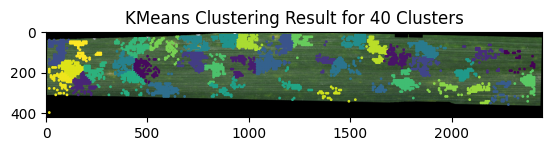

In [127]:
# Plot data points colored by cluster
plt.imshow(K.tensor_to_image(img_fixed))
plt.scatter(mkpts0_np[:, 0], mkpts0_np[:, 1], c=kmeans.labels_, s=1)

plt.title(f"KMeans Clustering Result for {n_clusters} Clusters")
plt.show()

### Pick highest confidence per cluster

In [130]:
vals = confidence[:20]
grps = torch.Tensor(kmeans.labels_[:20])
print(vals)
print(grps)

group_by_argmax(vals, grps)

tensor([0.8974, 0.8807, 0.8059, 0.8220, 0.9340, 0.9580, 0.9821, 0.9934, 0.9956,
        0.9987, 0.9995, 0.9845, 0.9938, 0.9962, 0.9951, 0.9721, 0.9580, 0.5092,
        0.3178, 0.5015])
tensor([275., 275., 275., 275., 153., 153., 153., 385., 385., 385., 198., 198.,
        198., 198., 379., 379., 379., 379., 367., 367.])


tensor([ 6, 10,  0, 19, 14,  9])

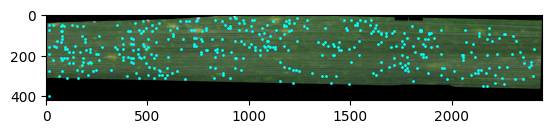

In [136]:
idx = group_by_argmax(confidence[confidence>threshold], torch.Tensor(kmeans.labels_))
cluster_max_coord = mkpts0_th[idx, :]
plt.imshow(K.tensor_to_image(img_fixed))
plt.scatter(cluster_max_coord[:, 0], cluster_max_coord[:, 1], color='cyan', s=1)
plt.show()

In [137]:
def filter_matches_by_cluster(mkpts0, mkpts1, confidence, threshold: float=0.5, n_clusters: int=400):

    # only consider above threshold
    mkpts0_th = mkpts0[confidence > threshold]
    mkpts1_th = mkpts1[confidence > threshold]

    # cluster remaining matches
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(mkpts0_th)
    
    # get indices of max per cell
    cluster_max_indices = group_by_argmax(confidence[confidence>threshold], torch.Tensor(kmeans.labels_))
    cluster_max_coord0 = mkpts0_th[cluster_max_indices, :]
    cluster_max_coord1 = mkpts1_th[cluster_max_indices, :]

    return cluster_max_coord0, cluster_max_coord1

Number of Matches: 400


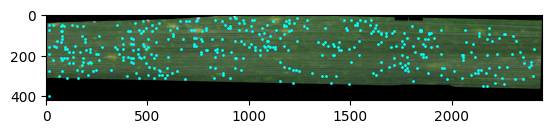

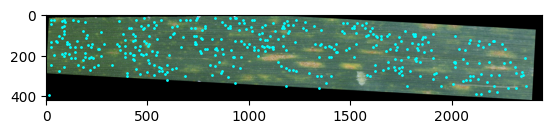

In [144]:
n_clusters=400
threshold=0.5
cluster_matches_fix, cluster_matches_mov = filter_matches_by_cluster(mkpts0, mkpts1, confidence, n_clusters=n_clusters, threshold=threshold)
print(f"Number of Matches: {cluster_matches_fix.shape[0]}")
plt.imshow(K.tensor_to_image(img_fixed))
plt.scatter(cluster_matches_fix[:, 0], cluster_matches_fix[:, 1], color='cyan', s=1)
plt.show()
plt.imshow(K.tensor_to_image(img_moving))
plt.scatter(cluster_matches_mov[:, 0], cluster_matches_mov[:, 1], color='cyan', s=1)
plt.show()

### TPS Test

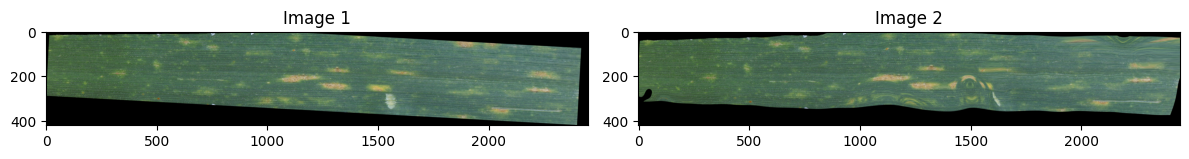

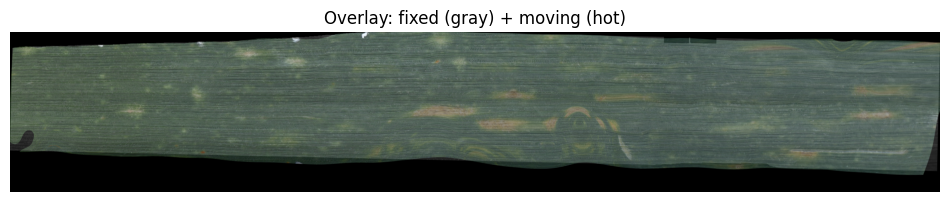

In [145]:
tps = ski.transform.ThinPlateSplineTransform.from_estimate(cluster_matches_fix, cluster_matches_mov)
out = warp_tps(img_moving, tps)
_=plot_image_pair(img_moving, out)
_=plot_overlay(img_fixed, out)

Setting threshold..
Threshold set to 0.9463129088000001
Estimating TPS transform...
Transforming moving image...


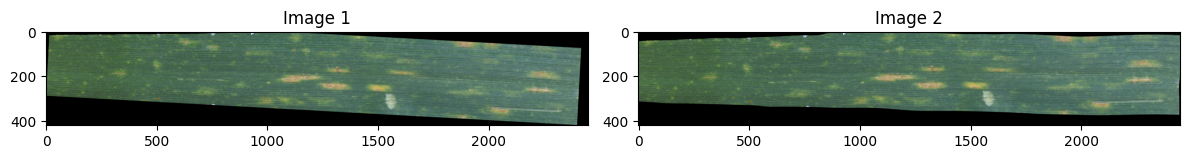

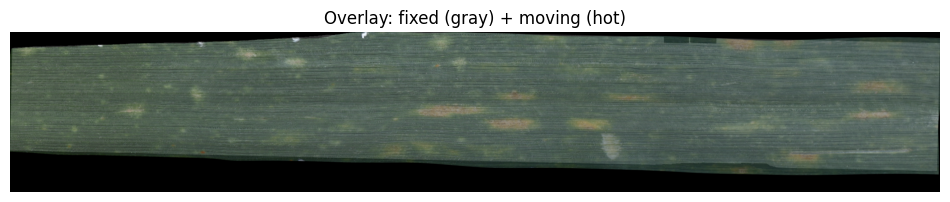

In [141]:
out_og, _ = tps_skimage(mkpts0, mkpts1, confidence, 0.5, img_moving, verbose=True)
_=plot_image_pair(img_moving, out_og)
_=plot_overlay(img_fixed, out_og)

## Enforcing Minimum Distance

In [161]:
import numpy as np
import torch


def filter_matches_by_min_distance(
    mkpts0,
    mkpts1,
    confidence,
    min_dist=20.0,
    max_points=None,
    threshold=0.5,
):
    """
    Greedy minimum-distance filtering for LoFTR matches.

    Args:
        kpts0: (N, 2) array/tensor of keypoints in image 0
        kpts1: (N, 2) array/tensor of keypoints in image 1
        confidence: (N,) match confidence
        min_dist: minimum pixel spacing between selected keypoints
        max_points: optional cap on number of matches

    Returns:
        filtered_kpts0, filtered_kpts1, filtered_conf
    """

    # Convert to numpy if torch
    if type(mkpts0) == torch.Tensor:
        mkpts0 = mkpts0.cpu().numpy()
    if type(mkpts1) == torch.Tensor:
        mkpts1 = mkpts1.cpu().numpy()
    if type(confidence) == torch.Tensor:
        confidence = confidence.cpu().numpy()

    # Sort by confidence descending
    idxs = np.argsort(-confidence)

    selected = []
    selected_points = []
    n_skip = 0

    for idx in idxs:
        if confidence[idx] < threshold:
            break

        pt = mkpts0[idx]

        if len(selected_points) == 0:
            # first point can just add to list
            selected.append(idx)
            selected_points.append(pt)
        else:
            # compute distances to existing points
            dists = np.linalg.norm(np.array(selected_points) - pt, axis=1)

            # ensure minimum distance isn't violated
            if np.min(dists) >= min_dist:
                selected.append(idx)
                selected_points.append(pt)
            else:
                n_skip += 1

        if max_points is not None and len(selected) >= max_points:
            print("max points reached")
            break

    selected = np.array(selected)
    print(f"points skipped: {n_skip}")

    return (
        mkpts0[selected],
        mkpts1[selected],
        # confidence[selected],
    )


points skipped: 2513
Number of Matches: 496


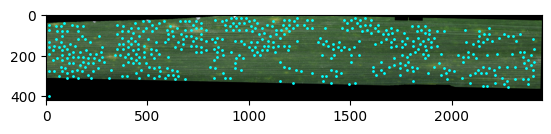

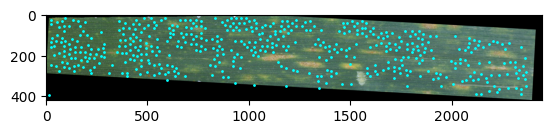

In [164]:
min_dist = 20
max_points=None
threshold=0.5
dist_matches_fix, dist_matches_mov = filter_matches_by_min_distance(mkpts0, mkpts1, confidence, min_dist=min_dist, max_points=max_points, threshold=threshold)
print(f"Number of Matches: {dist_matches_fix.shape[0]}")
plt.imshow(K.tensor_to_image(img_fixed))
plt.scatter(dist_matches_fix[:, 0], dist_matches_fix[:, 1], color='cyan', s=1)
plt.show()
plt.imshow(K.tensor_to_image(img_moving))
plt.scatter(dist_matches_mov[:, 0], dist_matches_mov[:, 1], color='cyan', s=1)
plt.show()

### TPS Test

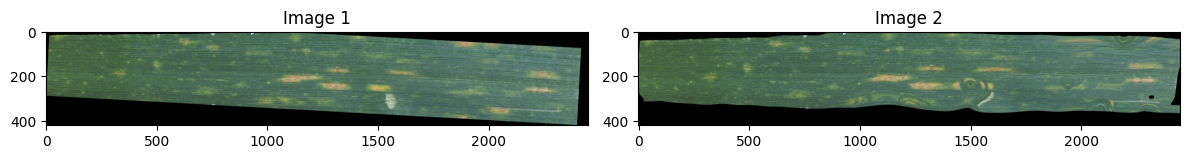

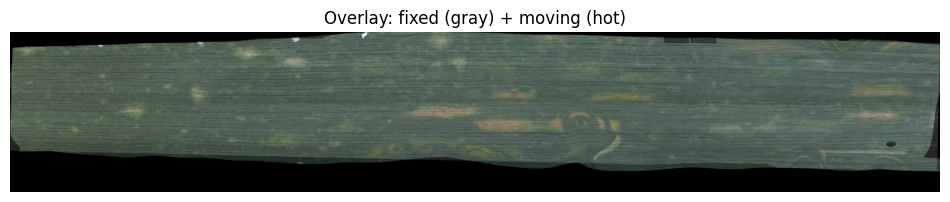

In [165]:
tps = ski.transform.ThinPlateSplineTransform.from_estimate(dist_matches_fix, dist_matches_mov)
out = warp_tps(img_moving, tps)
_=plot_image_pair(img_moving, out)
_=plot_overlay(img_fixed, out)

Setting threshold..
Threshold set to 0.9463129088000001
Estimating TPS transform...
Transforming moving image...


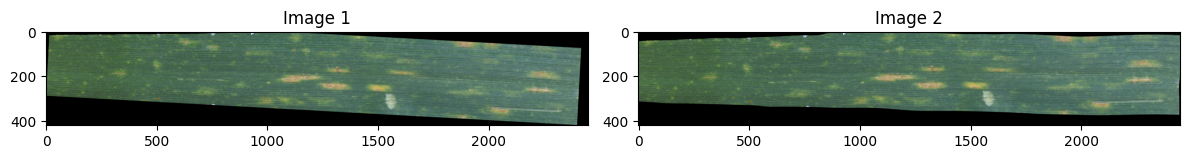

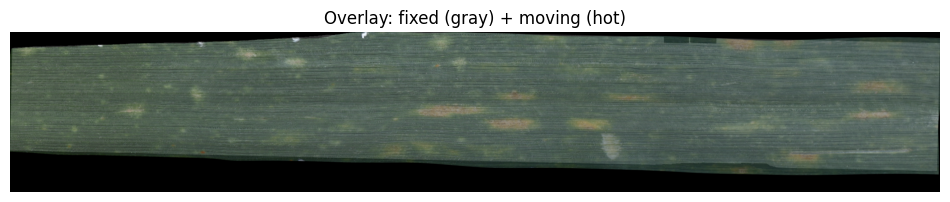

In [155]:
out_og, _ = tps_skimage(mkpts0, mkpts1, confidence, 0.5, img_moving, verbose=True)
_=plot_image_pair(img_moving, out_og)
_=plot_overlay(img_fixed, out_og)